<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong> Lukaz Martin Doehne
</div>

# PEC 4: Series temporales y combinación de modelos de regresión

Está actividad está dividida en dos partes:

 - **[Series temporales](#ej1)**: Descomponer y componer series temporales para realizar predicciones a futuro.
 - **[Combinación de clasificadores](#ej2)**: Estudio de diferentes métodos de combinación de clasificadores.

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de que se indique explícitamente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.
- En esta PEC se deben usar **únicamente las librerías que se importan a continuación**. Si se desea usar otra librería hay que consultarlo con el tutor/tutora del aula.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

Iniciamos la PEC con la carga de las siguientes librerías:

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn import svm

%matplotlib inline

<a id="ej1"></a>

# 1. Series temporales (6 puntos)

En este primer ejercicio trabajaremos con series temporales. Para ello, usaremos el dataset **temperatura.csv** que contiene la temperatura media mensual de Barcelona de los últimos 15 años, de 2008 a 2022.

Empezaremos leyendo los datos y observando gráficamente su distribución. Como se puede apreciar, es un claro caso de serie temporal, con heterocedasticidad, tendencia, periodo y ruido. A lo largo de este ejercicio trataremos cada uno de estos puntos.

In [2]:
data = pd.read_csv("temperatura.csv", parse_dates=['Year_Month'], index_col='Year_Month', header=0)
data.head()

,Temperature
Year_Month,
2008-01-01,10.1
2008-02-01,10.2
2008-03-01,10.8
2008-04-01,13.7
2008-05-01,16.6


<Axes: xlabel='Year_Month'>

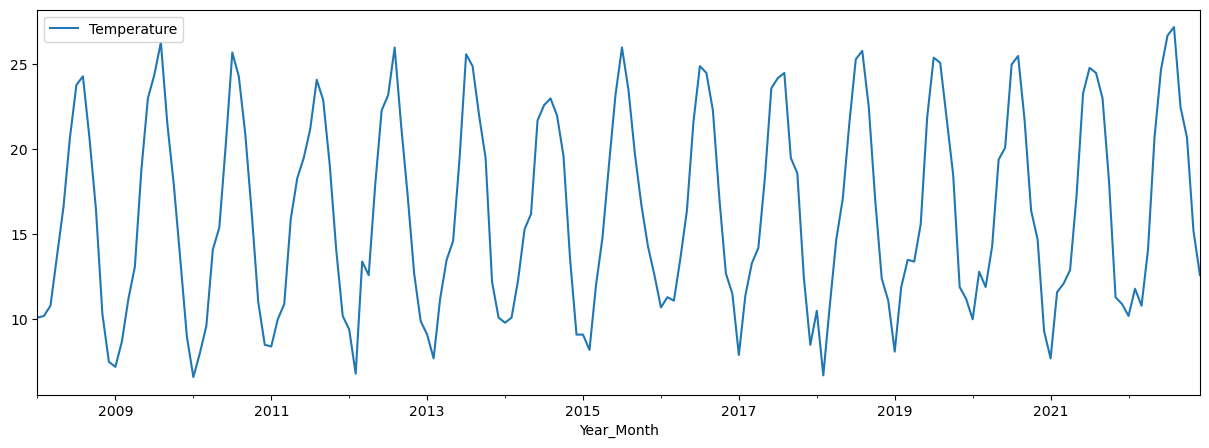

In [3]:
data.plot(figsize=(15, 5))

A continuación, vamos a separar los últimos tres años de datos del dataset original, los cuales nos servirán como conjunto de test. Así, cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales. El resto del conjunto de datos, será nuestro conjunto de datos de entrenamiento.

In [158]:
TEST_SIZE = 36
train, test = data.iloc[:-TEST_SIZE].to_numpy(), data.iloc[-TEST_SIZE:].to_numpy()
x_train, x_test = np.arange(train.shape[0]), np.arange(train.shape[0], data.shape[0])
train.shape, x_train.shape, test.shape, x_test.shape

((144, 1), (144,), (36, 1), (36,))

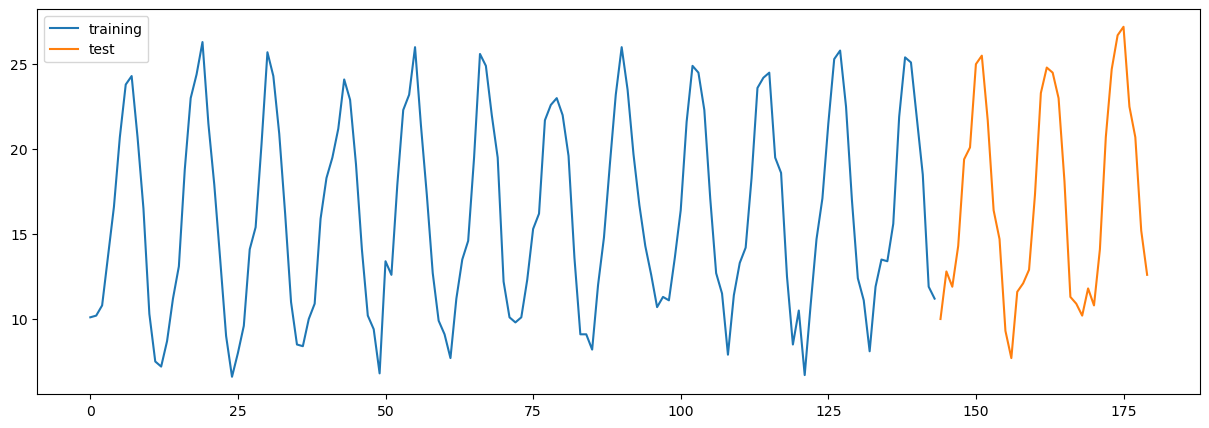

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train, label='training')
ax.plot(x_test, test, label='test')
ax.legend()

## 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad

Una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos una leve heterocedasticidad, ya que la amplitud de onda varía levemente con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> transforma los <strong>datos de entrenamiento</strong> para eliminar la heterocedasticidad. Para ello debéis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset (exponencial, logarítmica, ...). Estas funciones ya están implementadas en numpy. Graficar los datos originales junto con los datos transformados.
</div>

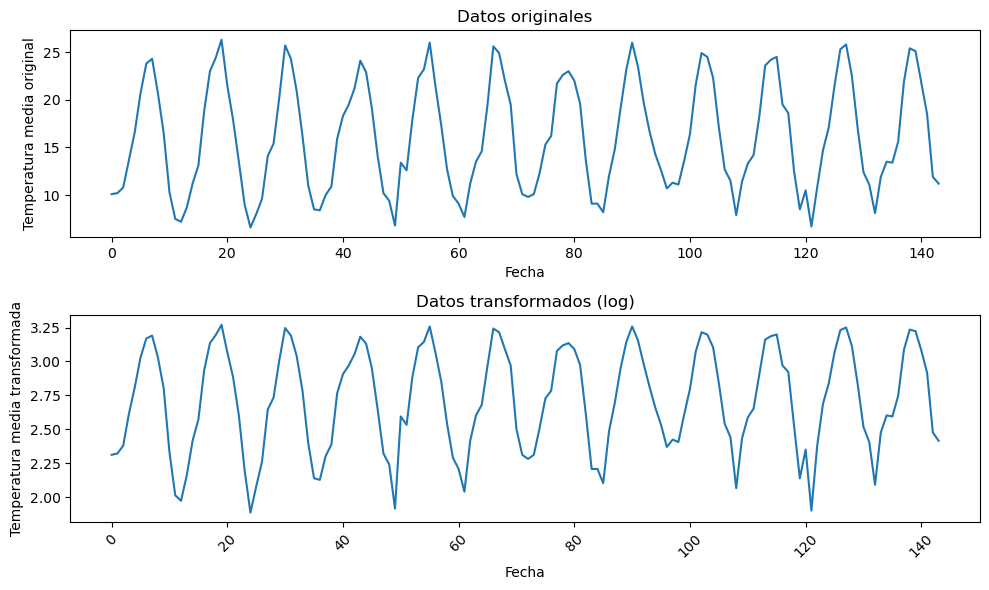

In [39]:
# Aplicamos la transformación logarítmica sobre el conjunto de entrenamiento
temperaturas_transformadas = np.log(train)

# Graficamos los datos originales y transformados
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(x_train, train)
plt.xlabel('Fecha')
plt.title('Datos originales')
plt.ylabel('Temperatura media original')
plt.subplot(2,1,2)
plt.plot(x_train, temperaturas_transformadas)
plt.xlabel('Fecha')
plt.title('Datos transformados (log)')
plt.ylabel('Temperatura media transformada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.1.b. Tendencia

La tendencia es el comportamento que tienen los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una ligera tendencia lineal creciente. En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> elimina la tendencia de los datos transformados en la sección anterior. Observando la serie, podemos apreciar que tenemos una tendencia lineal, por ese motivo, podemos ajustar una regresión lineal (usando scikit-learn) y sustraerla a los datos anteriores (entrenamiento sin heterocedasticidad). En este ejercicio, primero debemos graficar la serie con tendencia junto con la regresión lineal y, a continuación, se debe sustraer la tendencia y graficar la serie resultante (sin tendencia).
</div>

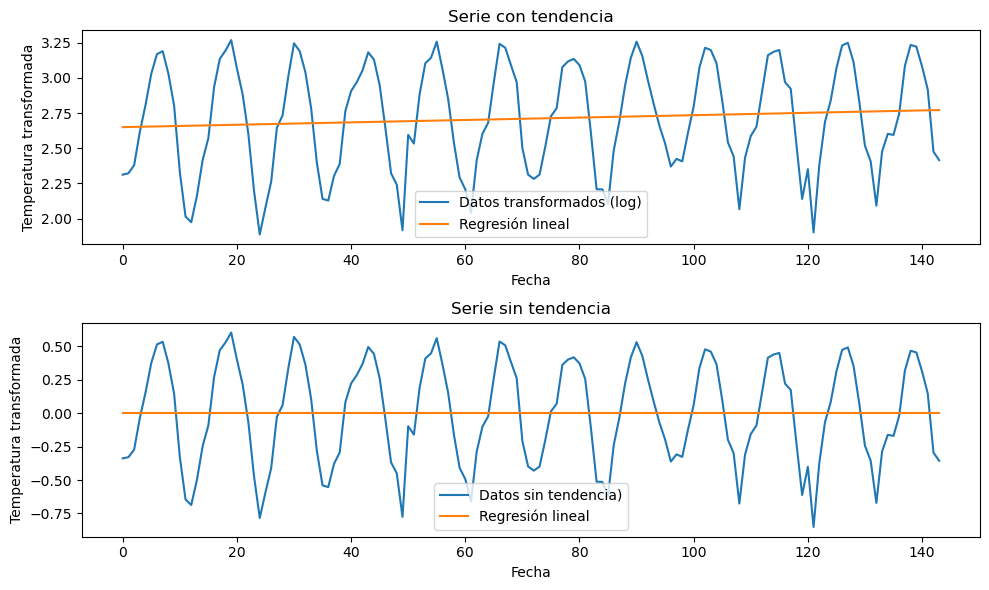

In [139]:
# Convertimos x_train en el formato adecuado
x_train_reshaped = np.array(x_train).reshape(-1, 1)

# Ajustamos la regresión lineal a los datos transformados (sin heterocedasticidad)
regresion_lineal = LinearRegression()
regresion_lineal.fit(x_train_reshaped, temperaturas_transformadas)

# Obtenemos la tendencia
tendencia = regresion_lineal.predict(x_train_reshaped)

# Sustraemos la tendencia de los datos transformados
serie_sin_tendencia = temperaturas_transformadas - tendencia

# Graficamos la serie con tendencia y la regresión lineal
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x_train, temperaturas_transformadas, label='Datos transformados (log)')
plt.plot(x_train, tendencia, label='Regresión lineal')
plt.xlabel('Fecha')
plt.ylabel('Temperatura transformada')
plt.title('Serie con tendencia')
plt.legend()

# Ajustamos la regresión lineal a los datos sin tendencia
regresion_lineal_st = LinearRegression()
regresion_lineal_st.fit(x_train_reshaped, serie_sin_tendencia)

# Obtenemos la regresion
regresion_st = regresion_lineal_st.predict(x_train_reshaped)

# Graficamos la serie sin tendencia
plt.subplot(2, 1, 2)
plt.plot(x_train, serie_sin_tendencia, label='Datos sin tendencia)')
plt.plot(x_train, regresion_st, label='Regresión lineal')
plt.xlabel('Fecha')
plt.ylabel('Temperatura transformada')
plt.title('Serie sin tendencia')
plt.legend()
plt.tight_layout()
plt.show()


### 1.1.c. Estacionalidad

Definimos la estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar y eliminar la estacionalidad.

#### 1.1.c.a. Encontrar el periodo de la estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> en primer lugar debéis encontrar el ciclo, es decir, cada cuánto se repiten los datos. Para ello, podemos usar la autocorrelación (numpy te permite obtener los coeficientes de correlación). En este ejercicio, se pide graficar los coeficientes para los 22 primeros valores de autocorrelación y determinar su valor máximo, el cual será nuestra estacionalidad. Dar una interpretación semántica del resultado obtenido.
</div>

<strong>Nota:</strong> utilizad la serie obtenida en el apartado anterior (sin tendencia ni heterocedasticidad).

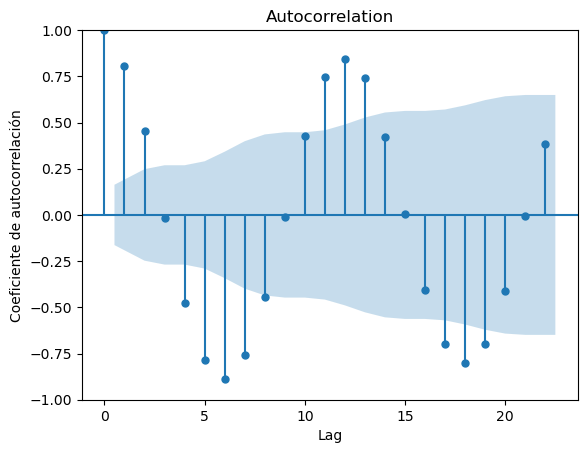

Periodo(Ciclo) de estacionalidad (indice): 11


In [98]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

# Calculamos los coeficientes de autocorrelación
acf = plot_acf(serie_sin_tendencia, lags=22, alpha=0.05)

# Usamos la función sm.tsa.acf para obtener los valores
acf_values = sm.tsa.acf(serie_sin_tendencia, alpha=0.05)

# Encontramos el periodo (indice) de la estacionalidad con el valor máximo
periodo_estacionalidad = np.argmax(acf_values[0][1:])

# Graficamos los coeficientes de autocorrelación
plt.xlabel('Lag')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()

# Mostramos el periodo de la estacionalidad
print(f"Periodo(Ciclo) de estacionalidad (indice): {periodo_estacionalidad}")

El valor 11 nos indica cada cuánto se repite un ciclo (mediante la mayor correlación). Es importante recordar que comenzamos con el índice 0, por lo que el índice 11 nos indica que el ciclo se repite cada 12 registros, es decir, cada 12 meses.

#### 1.1.c.b. Calcular el patrón de estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> ahora que ya conocéis el ciclo, debéis calcular el patrón (el molde de la estacionalidad). Es decir, para cada punto del ciclo, calcular la mediana de ese punto en cada uno de los ciclos de la serie. 
</div>

<strong>Nota:</strong> utilizad la serie obtenida en el apartado anterior (sin tendencia ni heterocedasticidad).

In [96]:
# Número de puntos por ciclo (meses)
puntos_por_ciclo = 12

# Inicializamos el patrón en 0
patron_estacionalidad = np.zeros(puntos_por_ciclo)

# Para cada mes del ciclo (año), calculamos la mediana y la asociamos al patron de estacionalidad
for i in range(puntos_por_ciclo):
    
    # Obtenemos los datos de cada mes
    datos_punto_ciclo = serie_sin_tendencia[i::puntos_por_ciclo]
    # Calculamos la mediana
    mediana_punto_ciclo = np.median(datos_punto_ciclo)
    # Asignamos la mediana al patrón de estacionalidad
    patron_estacionalidad[i] = mediana_punto_ciclo

# Mostramos el patrón de estacionalidad
print("Patrón de estacionalidad:")
print(patron_estacionalidad)

Patrón de estacionalidad:
[-0.50328039 -0.44896724 -0.25940646 -0.07877408  0.11948808  0.34899311
  0.47556924  0.49368463  0.3656317   0.14972606 -0.20364042 -0.4030677 ]


<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> una vez obtenido el patrón, replicadlo a lo largo de toda la serie temporal. Cuando lo hayáis calculado, debéis restarlo de la serie temporal (sin tendencia ni heterocedasticidad). Graficar los datos con estacionalidad junto con los datos sin estacionalidad.
</div>

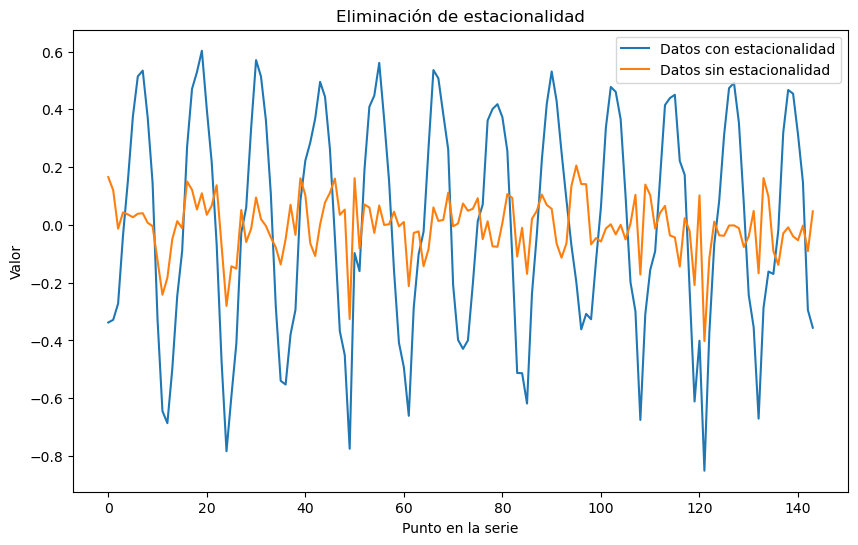

In [128]:
# Replicamos el patrón de estacionalidad a lo largo de toda la serie
patron_replicado = np.tile(patron_estacionalidad, len(serie_sin_tendencia)//len(patron_estacionalidad) + 1)[:len(serie_sin_tendencia)]

# Ajustamos el patron replicado al formato deseado
patron_replicado = np.array(patron_replicado).reshape(-1, 1)

# Restamos el patrón de estacionalidad de la serie transformada
serie_sin_estacionalidad = serie_sin_tendencia - patron_replicado

# Graficar los datos con estacionalidad y sin estacionalidad
plt.figure(figsize=(10, 6))
plt.plot(serie_sin_tendencia, label='Datos con estacionalidad')
plt.plot(serie_sin_estacionalidad, label='Datos sin estacionalidad')
plt.xlabel('Punto en la serie')
plt.ylabel('Valor')
plt.title('Eliminación de estacionalidad')
plt.legend()
plt.show()

### 1.1.d. Ruido

Una vez eliminadas la heterocedasticidad, la tendencia y la estacionalidad, lo que nos queda es el ruido. El ruido sigue una distribución normal. En este apartado debéis encontrar los parámetros de la distribución que sigue el ruido (media y desviación estandard).

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> encontrar la distribución que tiene el ruido (media y desviación estándard) usando el ruido obtenido en el apartado anterior, es decir, la serie sin heterocedasticidad, tendencia y estacionalidad. Podéis usar scipy.stats. Por último, graficad un histograma del ruido junto con un histograma de la distribución teórica que tiene el ruido.
</div>

La media es de -0.004663044711609641
La desviación estandar es de 0.10063491468558451


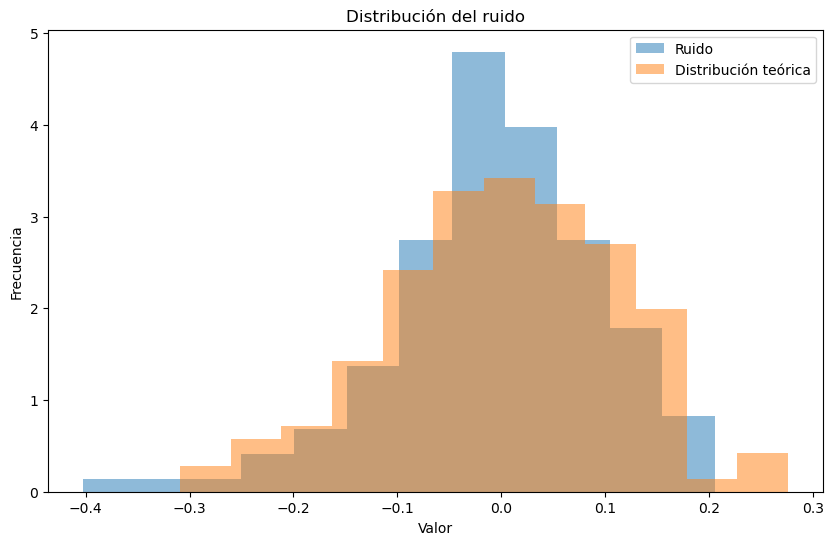

In [133]:
# Encontramos los parámetros de la distribución del ruido
media, desviacion_estandar = scipy.stats.norm.fit(serie_sin_estacionalidad)

print(f"La media es de {media}")
print(f"La desviación estandar es de {desviacion_estandar}")

# Generamos una muestra de la distribución teórica para el ruido
distribucion_teorica = scipy.stats.norm(media, desviacion_estandar)
muestra_teorica = distribucion_teorica.rvs(len(serie_sin_estacionalidad))

# Graficamos el histograma del ruido y distribución teórica
plt.figure(figsize=(10, 6))
plt.hist(serie_sin_estacionalidad, bins=12, density=True, alpha=0.5, label='Ruido')
plt.hist(muestra_teorica, bins=12, density=True, alpha=0.5, label='Distribución teórica')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución del ruido')
plt.legend()
plt.show()

## 1.2. Predicción

Una vez que hemos descompuesto la serie temporal (de entrenamiento), vamos a predecir los tres proximos años y comparar la predicción con los datos reales. Para ello seguiremos los siguientes pasos:

- Generar ruido
- Añadir estacionalidad
- Añadir tendencia
- Añadir heterocedasticidad

### 1.2.a. Ruido

Como hemos visto que el ruido se distribuye aleatoriamente siguiendo una distribución normal, vamos a generar ruido siguiendo esta distribución.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> genera tres años de datos de ruido (36 muestras) usando la distribución encontrada en el apartado 1.1.d. Podéis usar el módulo random de numpy. Por último, graficad el resultado.
</div>

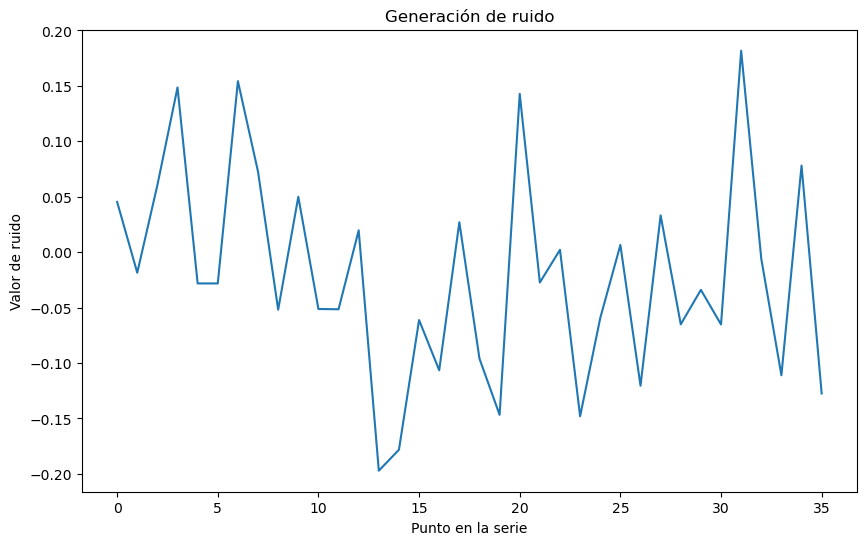

In [134]:
# Generar tres años de datos de ruido
np.random.seed(42)
ruido = np.random.normal(media, desviacion_estandar, 36)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(ruido)
plt.xlabel('Punto en la serie')
plt.ylabel('Valor de ruido')
plt.title('Generación de ruido')
plt.show()

### 1.2.b. Estacionalidad

Anteriormente hemos calculado la estacionalidad y el ciclo de la serie temporal. Vamos a usar esa estacionalidad ya calculada para añadirla a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los tres años de ruido calculados en el apartado anterior, la estacionalidad encontrada en el apartado 1.1.c. Grafica el resultado.
</div>

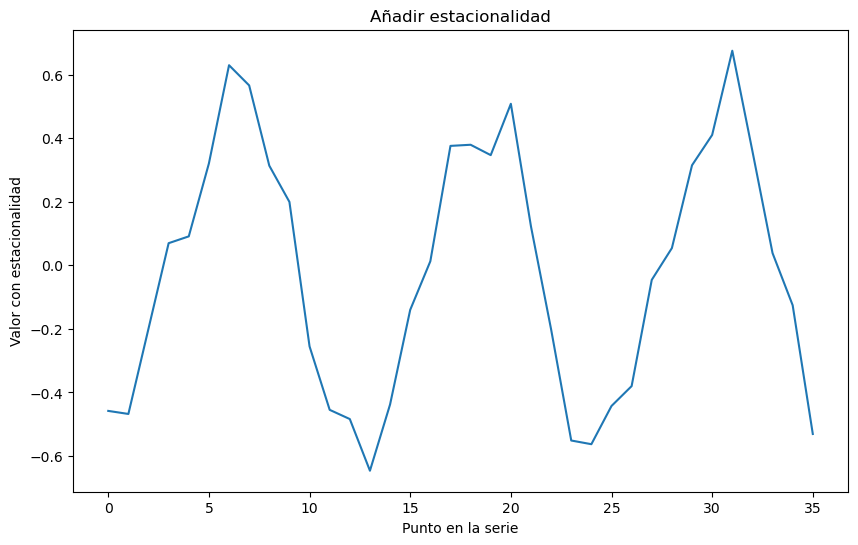

In [138]:
# Añadir estacionalidad al ruido
serie_con_estacionalidad = ruido + np.tile(patron_estacionalidad, 3)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(serie_con_estacionalidad)
plt.xlabel('Punto en la serie')
plt.ylabel('Valor con estacionalidad')
plt.title('Añadir estacionalidad')
plt.show()

### 1.2.c. Tendencia

En la sección 1.1.b hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Ahora, vamos a añadir esta tendencia a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los tres años de ruido y estacionalidad calculados en el apartado anterior, la tendencia encontrada en el apartado 1.1.b. Por último, graficad la serie obtenida.
</div>

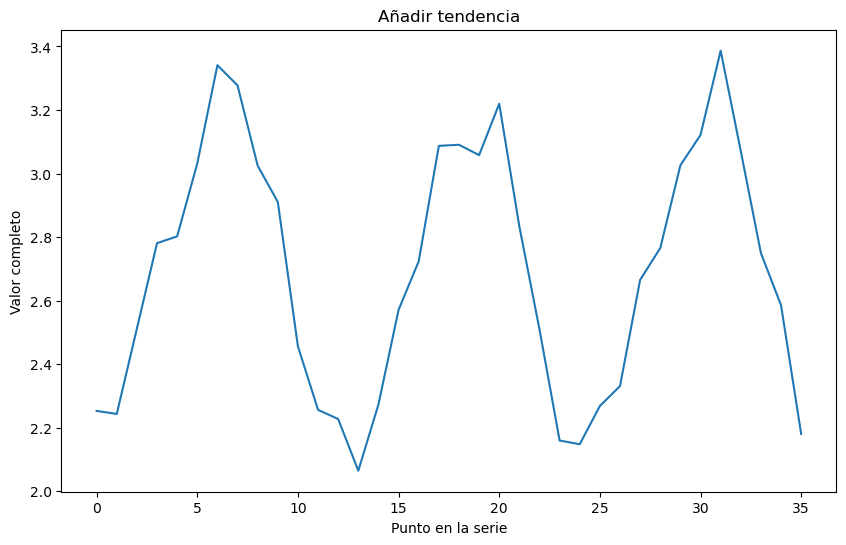

In [196]:
# Calculo la media de la tendencia inversa del punto 1.1.b
tendencia_inv = np.mean(temperaturas_transformadas - serie_sin_tendencia)

# Añadimos la tendencia calculada a la serie existente
serie_completa = serie_con_estacionalidad + tendencia_inv

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(serie_completa)
plt.xlabel('Punto en la serie')
plt.ylabel('Valor completo')
plt.title('Añadir tendencia')
plt.show()

### 1.2.d. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los tres años de ruido, estacionalidad y tendencia calculados en el apartado anterior, la heterocedasticidad, aplicando la función inversa a la encontrada en el apartado 1.1.a. Grafica el resultado junto con la serie completa y compara la predicción obtenida con los datos reales.
</div>

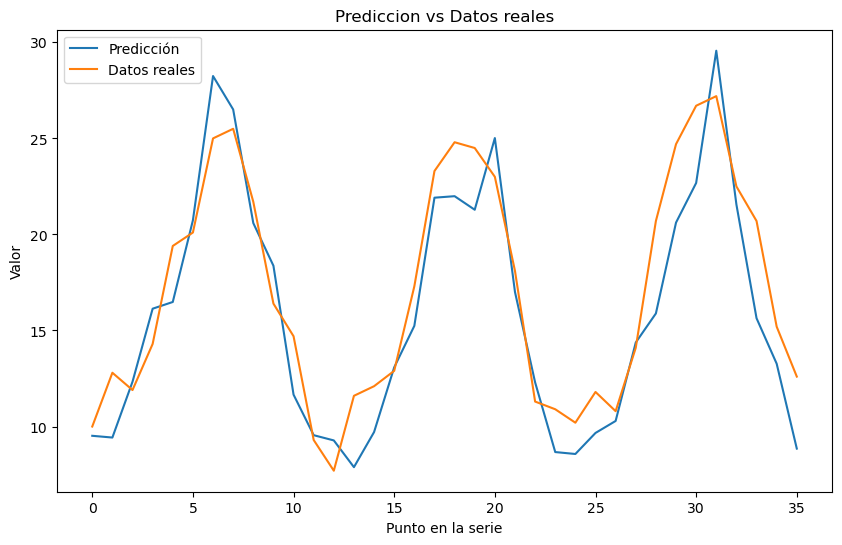

In [198]:
# Calculamos la inversa de la función del punto 1.1.a (np.log)
prediccion = np.exp(serie_completa)

# Graficar el resultado junto con la serie completa
plt.figure(figsize=(10, 6))
plt.plot(prediccion, label='Predicción')
plt.plot(test, label='Datos reales')
plt.xlabel('Punto en la serie')
plt.ylabel('Valor')
plt.title('Prediccion vs Datos reales')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> Analizad los resultados obtenidos.
</div>

En general, hemos obtenido resultados cercanos a los datos reales en nuestras predicciones. Sin embargo, debido a la naturaleza de los datos, que incluye componentes como la heterocedasticidad, el ruido y la estacionalidad, no podemos esperar predicciones perfectas, ya que afectan la precisión. Además, cabe mencionar que se han detectado correctamente las estaciones del año.

<a id="ej2"></a>

# 2. Combinación de clasificadores (4 puntos)

El ensemble learning es una estrategia en la que se utiliza un grupo de modelos para resolver un problema mediante la combinación estratégica de diversos modelos de aprendizaje automático en un sólo modelo predictivo.

En general, los métodos de ensemble se utilizan principalmente para mejorar la precisión del rendimiento general de un modelo y combinar varios modelos diferentes, también conocidos como aprendices básicos, para predecir los resultados, en lugar de utilizar un sólo modelo.

¿Por qué entrenamos tantos clasificadores diferentes en lugar de uno solo? Bueno, el uso de varios modelos para predecir el resultado final en realidad reduce la probabilidad de sopesar las decisiones tomadas por modelos deficientes (sobreentrenados, no debidamente ajustados...).

Cuanto más diversos sean estos aprendices básicos, más poderoso será el modelo final.

Tengamos en cuenta que en cualquier modelo de aprendizaje automático, el error de generalización viene dado por la suma de cuadrados de bias + varianza + error irreductible.

¡Los errores irreductibles son algo que está más allá de nosotros! No podemos reducirlos.

Sin embargo, utilizando ensembles, podemos reducir el sesgo (bias) y la varianza de un modelo. Esto reduce el error de generalización general.

La <strong>compensación de sesgo-varianza</strong> es el punto de referencia más importante que diferencia un modelo robusto de uno inferior (entendamos por inferior un modelo no demasiado generalizable).

Aunque no es una regla exacta, en el aprendizaje automático, los modelos que tienen un sesgo alto tienden a tener una varianza más baja y viceversa.

Hemos estado hablando de bias y varianza. Pero veamos que entendemos por sesgo de un modelo y por varianza de un modelo.

1. <strong>Sesgo</strong>: El sesgo es un error que surge debido a suposiciones falsas realizadas en la fase de aprendizaje de un modelo. Un sesgo alto puede hacer que un algoritmo de aprendizaje omita información importante y correlaciones entre las variables independientes y las etiquetas de clase, por lo que no se ajusta al modelo.

2. <strong>Varianza</strong>: la varianza nos dice qué tan sensible es un modelo a los pequeños cambios en los datos de entrenamiento. Es decir, cuánto cambia el modelo. Una gran variación en un modelo lo hará propenso al ruido aleatorio presente en el conjunto de datos, por lo que se ajustará demasiado al modelo.

Para comprender con más detalle la compensación de sesgo y varianza en los modelos de aprendizaje automático, podeís consultar este [artículo](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229).

Una vez llegados a este punto, podemos dividir los ensembles en cuatro categorías:

1. <strong>Bagging</strong>: El bagging se utiliza principalmente para reducir la variación en un modelo. Un ejemplo simple de bagging es el algoritmo Random Forest.

2. <strong>Boosting</strong>: El boosting se utiliza principalmente para reducir el sesgo en un modelo. Ejemplos de algoritmos de impulso son Ada-Boost, XGBoost, árboles de decisión mejorados por gradiente, etc.

3. <strong>Stacking</strong>: el stacking se utiliza principalmente para aumentar la precisión de predicción de un modelo.

4. <strong>Cascading</strong>: esta clase de modelos son muy precisos. La conexión en cascada se usa principalmente en escenarios en los que no puede permitirse cometer un error. Por ejemplo, una técnica en cascada se usa principalmente para detectar transacciones fraudulentas con tarjetas de crédito.

## Datos

Para este ejercicio usaremos el dataset <strong>diabetes.csv</strong>. Este conjunto de datos es original del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo de este dataset es predecir, basándose en las mediciones de diagnóstico, si un paciente tiene diabetes.

En particular, todos los pacientes aquí son mujeres de al menos 21 años de ascendencia india Pima.

El dataset contiene la siguiente información:

- Embarazos: número de embarazos 
- Glucosa: concentración de glucosa en plasma a 2 horas en una prueba de tolerancia a la glucosa oral 
- Presión arterial: presión arterial diastólica (mm Hg) 
- SkinThickness: Espesor del pliegue cutáneo del tríceps (mm) 
- Insulina: insulina sérica de 2 horas (mu U / ml) 
- IMC: índice de masa corporal (peso en kg / (altura en m) ^ 2) 
- DiabetesPedigreeFunction: función del pedigrí de la diabetes 
- Edad: Edad (años) 
- Resultado (variable objetivo): variable de clase (0 o 1)

En la primera parte de este ejercicio veremos la combinación de clasificadores en paralelo mediante las tecnicas de <strong>Bagging</strong> y <strong>Boosting</strong>.

En la segunda parte intentaremos mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: <strong>Stacking</strong> y <strong>Cascading</strong>.

Para empezar, veamos como es el dataset.

In [199]:
diabetes = pd.read_csv('diabetes.csv')

nRow, nCol = diabetes.shape
print(f'Hay {nRow} filas y {nCol} columnas')
diabetes.head()

Hay 768 filas y 9 columnas


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Para poder probar varios modelos, primero vamos a dividir el dataset entre train y test. Además, para que todos obtengáis los mismos resultados y poder comentar dudas por el foro/correo, fijaremos la seed para obtener los mismos datasets de train y test.

Como en este ejercicio trataremos stacking y cascading, y ambos se aplican sobre el conjunto de test, haremos un split del 60% para tener un poco más de base al aplicar estas dos técnicas.

In [200]:
myseed = 13
X = diabetes.drop(columns = 'Outcome')
y = diabetes['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=myseed)

## 2.1. Combinación paralela de clasificadores (1.5 puntos)

### 2.1.1. Árboles de decisión

Para poder comparar el aumento de performance obtenido a medida que vamos aplicando técnicas nuevas, utilizaremos como baseline un simple árbol de decisión.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Define un árbol de decisión con profundidad máxima de 3 niveles (aplicaremos la misma restricción en las siguientes secciones), utilizando la semilla definida en el apartado anterior y calcula su precisión sobre el conjunto de train aplicando validación cruzada con 5 conjuntos. A continuación, entrena el árbol de decisión sobre el conjunto de datos de train y evalua sobre test utilizando la precisión como métrica ('accuracy'). <strong>Sugerencia:</strong> usar el módulo <strong>cross_val_score</strong> de <strong>sklearn</strong>.
</div>

Para aprender más sobre <strong>cross validation</strong> y sobre como usar estos módulos, os recomendamos los siguientes enlaces:
- [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
- [cross_validation](http://scikit-learn.org/stable/modules/cross_validation.html)

In [224]:
# Creamos una función para su posterior uso
def train_model(model):
    # Calculamos la precisión mediante validación cruzada en 5 conjuntos
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    print("Precisión (cross-validation):", cv_scores.mean())
    
    # Entrenamos el árbol de decisión con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Evaluamos el árbol de decisión con los datos de prueba
    accuracy = model.score(X_test, y_test)

    print("Precisión (test set):", accuracy)
    
    return model

In [225]:
# Definicion del árbol de decisión con una profundidad máxima de 3 y la semilla definida
tree = DecisionTreeClassifier(max_depth=3, random_state=myseed)
tree = train_model(tree)

Precisión (cross-validation): 0.7006874669487043
Precisión (test set): 0.7288503253796096


<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> Analizad los resultados obtenidos.
</div>

El árbol de decisión ha obtenido una precisión de 0.729. Esto indica que, en promedio, el modelo fue capaz de predecir correctamente la mayoría de los casos del conjunto de test.

En general, se puede concluir que el árbol de decisión con una profundidad máxima de 3 niveles tiene un rendimiento moderado en términos de precisión y es probable que otras técnicas o modelos funcionen mejor.

### 2.1.2. Bagging

La idea central del bagging es usar réplicas del conjunto de datos original y usarlas para entrenar diferentes clasificadores.

Crearemos subconjuntos muestreando aleatoriamente un montón de puntos del conjunto de datos de entrenamiento con reemplazo.

Ahora entrenaremos clasificadores individuales en cada uno de estos subconjuntos bootstrap.

Cada uno de estos clasificadores base predecirá la etiqueta de clase para un problema dado. Aquí es donde combinamos las predicciones de todos los modelos base. Esta parte se llama etapa de agregación. Es por eso que encontraréis los ensembles bagging por el nombre de ensembles de agregación.

Por lo general, se usa un voto de mayoría simple en un sistema de clasificación y se toma la media de todas las predicciones para los modelos de regresión para combinar todos los clasificadores base en un solo modelo y proporcionar el resultado final del modelo de conjunto.

Un ejemplo simple de tal enfoque es el algoritmo Random Forest. El bagging reduce la alta variación (varianza) de un modelo, reduciendo así el error de generalización. Es un método muy eficaz, especialmente cuando tenemos datos muy limitados con pudiera ser nuestro caso.

Mediante el uso de muestras de bootstrap, podemos obtener una estimación agregando las puntuaciones de muchas muestras.

<strong>¿Cómo haríamos bagging?</strong>

Supongamos que tenemos un conjunto de entrenamiento que contiene 100.000 puntos de datos.

Crearíamos N subconjuntos muestreando al azar 50K puntos de datos para cada subconjunto.

Cada uno de estos N subconjuntos se utilizará para entrenar N clasificadores diferentes.

En la etapa de agregación, todas estas N predicciones se combinarán en un solo modelo, también llamado metaclasificador.

De los 100.000 puntos presentes originalmente en el conjunto de datos, si eliminamos 1000 puntos, el impacto que tendrá en los conjuntos de datos muestreados será muy inferior.

Si pensamos intuitivamente, es posible que algunos de estos 1000 puntos no estén presentes en todos los conjuntos de datos muestreados y, por lo tanto, la cantidad de puntos que se eliminarán de cada conjunto de datos muestreados será muy inferior. ¡Incluso cero en algunos casos! En resumen, el impacto de eliminar 1000 puntos de este tipo será en realidad menor en los clasificadores base, lo que reducirá la variación en un modelo y lo hará más sólido.

La varianza no es más que sensibilidad al ruido, como hemos comentado anteriormente.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Define un Random Forest Classifier con 20 árboles de decisión y profundidad máxima de 3 niveles, utilizando la semilla definida al inicio del segundo ejercicio, y calcula su precisión sobre el conjunto de train aplicando validación cruzada con 5 conjuntos. A continuación, entrena el modelo sobre el conjunto de datos de train y evalua sobre test utilizando la precisión como métrica ('accuracy'). 
</div>

<strong>Sugerencia:</strong> Usar el módulo `RandomForestClassifier` de **sklearn**. 

Para apender a usar este módulo os recomendamos el siguiente:
- [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [226]:
from sklearn.ensemble import RandomForestClassifier
# Definimos el Random Forest Classifier con 20 árboles y profundidad máxima de 3 niveles
forest = RandomForestClassifier(n_estimators=20, max_depth=3, random_state=myseed)
forest = train_model(forest)

Precisión (cross-validation): 0.7361713379164463
Precisión (test set): 0.7527114967462039


<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> Analizad los resultados obtenidos.
</div>

En este caso, se ha obtenido una precisión en el conjunto de pruebas de 0.753 utilizando el modelo RandomForestClassifier, lo cual representa una mejora en comparación con el modelo DecisionTreeClassifier. Estos resultados demuestran el beneficio de utilizar la metodología de bagging.

### 2.1.3. Boosting

El boosting se utiliza para convertir a los clasificadores de base débil en fuertes. Los clasificadores débiles generalmente tienen una correlación muy débil con las etiquetas de clase verdaderas y los clasificadores fuertes tienen una correlación muy alta entre el modelo y las etiquetas de clase verdaderas.

El boosting capacita a los clasificadores débiles de manera iterativa, cada uno tratando de corregir el error cometido por el modelo anterior. Esto se logra entrenando un modelo débil en todos los datos de entrenamiento, luego construyendo un segundo modelo que tiene como objetivo corregir los errores cometidos por el primer modelo. Luego construimos un tercer modelo que intenta corregir los errores cometidos por el segundo modelo y así sucesivamente. Los modelos se agregan de forma iterativa hasta que el modelo final ha corregido todos los errores cometidos por todos los modelos anteriores.

Cuando se agregan los modelos en cada etapa, se asignan algunos pesos al modelo que está relacionado con la precisión del modelo anterior. Después de agregar un clasificador débil, los pesos se vuelven a ajustar. Los puntos clasificados incorrectamente reciben pesos más altos y los puntos clasificados correctamente reciben pesos más bajos. Este enfoque hará que el siguiente clasificador se centre en los errores cometidos por el modelo anterior.

El boosting reduce el error de generalización tomando un modelo de alto bias y baja varianza y reduciendo el bias en un nivel significativo. Recuerde, el bagging reduce la varianza. Al igual que el bagging, el boosting también nos permite trabajar con modelos de clasificación y regresión.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Define un Gradient Boosting Classifier con 20 árboles de decisión y profundidad máxima de 3 niveles, utilizando la semilla definida al inicio del segundo ejercicio, y calcula su precisión sobre el conjunto de train aplicando validación cruzada con 5 conjuntos. A continuación, entrena el modelo sobre el conjunto de datos de train y evalua sobre test utilizando la precisión como métrica ('accuracy').
</div>
    
<strong>Sugerencia:</strong> 
- Usar el módulo [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) de **sklearn**.

In [227]:
from sklearn.ensemble import GradientBoostingClassifier
# Definimos el Gradient Boosting Classifier con 20 árboles y profundidad máxima de 3 niveles
gb_classifier = GradientBoostingClassifier(n_estimators=20, max_depth=3, random_state=myseed)
gb_classifier = train_model(gb_classifier)

Precisión (cross-validation): 0.7461660497091487
Precisión (test set): 0.7527114967462039


<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> Analizad los resultados obtenidos.
</div>

Similar al modelo de bagging, se ha obtenido una precisión de 0.753 utilizando el modelo de Gradient Boosting Classifier. Esto demuestra que el uso de boosting proporciona mejoras en comparación con el modelo regular de DecisionTreeClassifier.

Aun así, una precisión de 0.753 puede considerarse moderadamente buena, pero aún se pueden explorar otros algoritmos de aprendizaje automático para buscar mejoras adicionales.

## 2.2. Combinación secuencial de clasificadores base diferentes (2.5 puntos)

Para poder hacer combinación secuencial de modelos, necesitamos tener varios modelos diferentes entrenados. En nuestro caso, ya tenemos un árbol de decisión. Vamos a entrenar un par de modelos más.

### 2.2.1 KNN (k vecinos más próximos)

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Define un K-Neighbors Classifier con 2 vecinos y calcula su precisión sobre el conjunto de train aplicando validación cruzada con 5 conjuntos. A continuación, entrena el modelo sobre el conjunto de datos de train y evalua sobre test utilizando la precisión como métrica ('accuracy').</div>

In [229]:
from sklearn.neighbors import KNeighborsClassifier

# Definimos el K-Neighbors Classifier con 2 vecinos
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier = train_model(knn_classifier)

Precisión (cross-validation): 0.7004230565838181
Precisión (test set): 0.6832971800433839


### 2.2.2 SVM (Support Vector Machines)

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Define un SVM con gamma = 0.07 y calcula su precisión sobre el conjunto de train aplicando validación cruzada con 5 conjuntos. A continuación, entrena el modelo sobre el conjunto de datos de train y evalua sobre test utilizando la precisión como métrica ('accuracy').</div>

In [230]:
from sklearn.svm import SVC

# Definimos el SVM con gamma = 0.07
svm_classifier = SVC(gamma=0.07)
svm_classifier = train_model(svm_classifier)

Precisión (cross-validation): 0.6612374405076678
Precisión (test set): 0.6442516268980477


### 2.2.3 Stacking

Todos los modelos individuales se entrenan por separado en el conjunto completo de datos de entrenamiento y se ajustan para lograr una mayor precisión. La compensación de bias y varianza se tiene en cuenta para cada modelo. El modelo final, también conocido como metaclasificador, se alimenta de las etiquetas de clase predichas por los modelos base o de las probabilidades predichas para cada etiqueta de clase. Luego, el metaclasificador se entrena en función de los resultados dados por los modelos base.

En el stacking, se entrena un nuevo modelo en función de las predicciones realizadas por los modelos anteriores. Este proceso se lleva a cabo de forma secuencial. Esto significa que varios modelos se entrenan en la etapa 1 y se ajustan con precisión. Las probabilidades pronosticadas de cada modelo de la etapa 1 se alimentan como entrada a todos los modelos en la etapa 2. Los modelos en la etapa 2 luego se ajustan con precisión y las salidas correspondientes se alimentan a los modelos en la etapa 3 y así sucesivamente. Este proceso se produce varias veces en función de la cantidad de capas de apilamiento que desee utilizar.

La etapa final consiste en un único modelo que nos da el resultado final al combinar el resultado de todos los modelos presentes en las capas anteriores.

A menudo, el uso de clasificadores apilables aumenta la precisión de predicción de un modelo. ¡Pero de ninguna manera puede garantizarse que el uso de apilamiento aumente la precisión de la predicción en todo momento! Echad un vistazo al siguiente [link](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/).

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Construye un clasificador de tipo stacking usando un Gradient Boosting Classifier (con 20 árboles de decisión, profundidad máxima de 3 niveles y la semilla definida al inicio del segundo ejercicio) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: árbol de decisión, knn y svm. A continuación, calcula la precisión del modelo resultante con <strong>cross-validation</strong> en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test). 
</div>

<strong>Sugerencia:</strong> 
- Usar la función `column_stack` de <strong>numpy</strong> para juntar todas las predicciones. 

Para más información, puedes consultar este enlace:
- [column_stack](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html)

In [231]:
# Obtenemos las predicciones de los clasificadores base sobre el conjunto de test
dt_predictions = tree.predict(X_test)
knn_predictions = knn_classifier.predict(X_test)
svm_predictions = svm_classifier.predict(X_test)

# Juntamos las predicciones en una matriz
stacking_features = np.column_stack((dt_predictions, knn_predictions, svm_predictions))

# Definimos el Gradient Boosting Classifier como clasificador final
stacking_classifier = GradientBoostingClassifier(n_estimators=20, max_depth=3, random_state=myseed)

# Calculamos la precisión mediante validación cruzada en el conjunto de test
cv_scores = cross_val_score(stacking_classifier, stacking_features, y_test, cv=5, scoring='accuracy')

print("Precisión (cross-validation):", cv_scores.mean())

Precisión (cross-validation): 0.7158719027582983


<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> ¿Has conseguido mejorar la precisión gracias al stacking? Comenta los resultados.
</div>

Los resultados no mostraron una mejora significativa en comparación con el árbol de decisión. El clasificador de tipo stacking obtuvo una precisión de 0.716, mientras que el árbol de decisión alcanzó una precisión de 0.729 en el conjunto de pruebas. Sin embargo, es importante destacar que la precisión del clasificador de tipo stacking es mejor que la de KNN o SVM individualmente.

A pesar de no lograr una mejora notable en términos de precisión, el enfoque de stacking sigue siendo una técnica interesante ya que puede proporcionar una mayor consistencia en las predicciones al combinar múltiples modelos.

### 2.2.4. Cascading

El caso de cascading es parecido al de stacking pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Construye un clasificador de tipo cascading usando un Gradient Boosting Classifier (con 20 árboles de decisión, profundidad máxima de 3 niveles y la semilla definida al inicio del segundo ejercicio) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el stacking), y también las variables originales. Calcula la precisión del modelo resultante con <i>cross-validation</i> en el conjunto de test.
</div>

**Sugerencia**: 
- Usa el mismo conjunto de datos que en el ejercicio anterior pero añade *X_test*.

In [218]:
# Juntamos las predicciones con las variables originales
cascading_features = np.column_stack((X_test, dt_predictions, knn_predictions, svm_predictions))

# Definimos el Gradient Boosting Classifier como clasificador final
cascading_classifier = GradientBoostingClassifier(n_estimators=20, max_depth=3, random_state=myseed)

# Calculamos la precisión mediante validación cruzada en el conjunto de test
cv_scores = cross_val_score(cascading_classifier, cascading_features, y_test, cv=5, scoring='accuracy')

print("Precisión (cross-validation):", cv_scores.mean())

Precisión (cross-validation): 0.7614305750350631


<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> Has conseguido mejorar la precisión gracias al cascading? Comenta los resultados.
</div>

Si, en este caso se ha conseguido una mejora en la precisión obteniendo 0.761. Al añadir las variables originales en el clasificador cascading hemos mejorado la precisión de 0.729 a 0.761.

Sí, en este caso se ha logrado una mejora en la precisión al obtener un valor de 0.761. Al agregar las variables originales al clasificador cascading, se ha mejorado la precisión desde 0.729 a 0.761. Esta mejora sugiere que la combinación de las predicciones de los modelos anteriores con las variables originales aporta información adicional y permite obtener mejores resultados.